myfit.py: Loaded GB_vif from data/GB_vif.pickle
Treat5.py:pred: created data/GB_vif_pred.csv
Treat5.py:confirm: data/GB_vif_confirm.csv
Treat5.py:get_plot: created data/GB_vif_pred_confirm.pdf
rpt2tex:p1: Created file data/GB_vif_pred_confirm.tex using data/GB_vif_pred_confirm.pdf
myfit.py: Loaded RF_vif from data/RF_vif.pickle
Treat5.py:pred: created data/RF_vif_pred.csv
Treat5.py:confirm: data/RF_vif_confirm.csv
Treat5.py:get_plot: created data/RF_vif_pred_confirm.pdf
rpt2tex:p1: Created file data/RF_vif_pred_confirm.tex using data/RF_vif_pred_confirm.pdf
myfit.py: Loaded LR from data/LR.pickle
Treat5.py:pred: created data/LR_pred.csv
Treat5.py:confirm: data/LR_confirm.csv
Treat5.py:get_plot: created data/LR_pred_confirm.pdf
rpt2tex:p1: Created file data/LR_pred_confirm.tex using data/LR_pred_confirm.pdf
myfit.py: Loaded DT from data/DT.pickle
Treat5.py:pred: created data/DT_pred.csv
Treat5.py:confirm: data/DT_confirm.csv
Treat5.py:get_plot: created data/DT_pred_confirm.pdf
rpt2tex:p

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

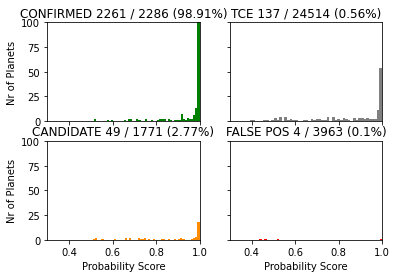

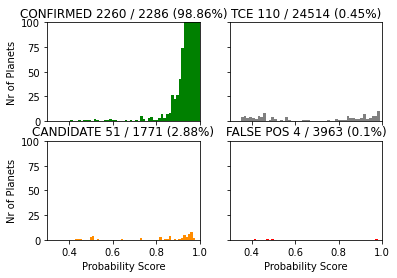

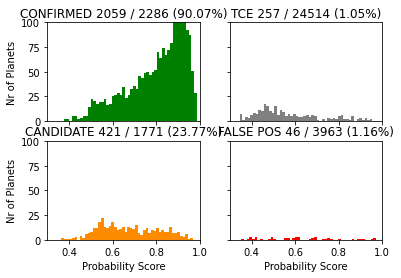

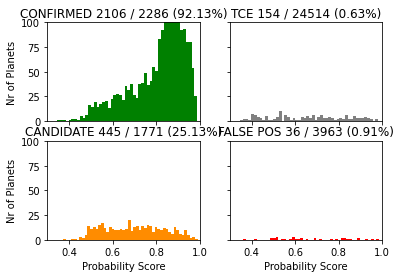

In [1]:
#!/home/admin/anaconda3/bin/python3
#   author:martinmhan@yahoo.com date:  21/06/2020
#   Copyright (C) <2020>  <Martin Mohan>
#
#   This program is free software; you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation; either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program; if not, write to the Free Software Foundation,
#   Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301  USA
#print(__doc__)
#import joblib,argparse,re,sys,glob,os,time
import argparse,re,sys,glob,os,time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn.metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
import json
import pprint
import myfit
import rpt2tex
import mmodels
import csv2tex

class Treat5():
    """ Given ifile and model name select the correct classifier.
    Load pickle file created by Treat4.py (name derived from ifile, model).
    Read ifile e.g. data/TK.csv and split into X,y
    Run Classifier with X,y data.
    Load TCE1 file containing X data only.
    Run X against predcition and create file self.predFile
    Save self.predFile as kepid,tce_plnt_num,kepoi_name,koi_disosition,y_pred

    """
    def __init__(self):
        """ 

        """
        pass
        # self.ifile and self.TCE1file generated from modelname 
#        xfit=myfit.myfit(fit,model)
#        # IMPORTANT name
#        self.ifile=xfit.ifile
##        self.bTK=xfit.bTK
#        ofile=xfit.ofile
#        self.clf=xfit.clf
#        self.model=model
#        self.crefmodel=crefmodel
#        self.crefConfirmFile="data/"+self.crefmodel+"_confirm.csv"
#        self.crefFile="data/"+self.model+"_"+self.crefmodel+"_cref.csv"
#        self.df=xfit.fit_all() # Use all X and y for prediction
#        self.predFile=ofile+"_pred.csv" # all prediction file
#        self.ConfirmFile=ofile+"_confirm.csv" # Predicted confirmed (but labelled otherwise)
#        # IMPORTANT name
#        self.TCE1file=self.ifile.replace("TK", "TCE1") # Prediction file must already exist and have same extensions as TK... TCE1_...

    def save_clf(self):    
        a=mmodels.mmodels(argv.model)
        output="\\begin{verbatim}\n\
        %s\n\
        \\end{verbatim}" %(a.clf)
#        clftex=self.ofile+"_clf.tex"
        with open(self.clftex,'w') as f: f.write(output)
        print(f"Saved Clf in {self.clftex}")

    # Merge data/KOI.csv and data/TCE.csv to data/TK.csv
    def getKepid(self,pfile,koi1):
        """ Generate Kepid. The KOI table contains kepid and kepoi_name (e.g. K00082.01)
        The TCE contains kepid and tce_plnt_num. This joins tables on kepid, tce_plnt_numb

        """
        for index, row in koi1.iterrows():
#            koi1.loc[index,'tce_plnt_num'] = self.get_plnt_num(row['kepoi_name'])
            x=re.findall(r'\d$', row['kepoi_name']) # K00001.01 -> ['1']
            y=list(map(int, x)) # ['1'] -> 1 doesn't work?
            koi1.loc[index,'tce_plnt_num'] = int(y[0])

        koi1.tce_plnt_num = koi1.tce_plnt_num.astype(int) # ['1.0'] -> ['1']
        df=koi1.merge(pfile, indicator=True, how='outer')
        df=df.drop(['_merge'], axis=1)
        return df

    def pred(self,fit,model):
        """ 
        Get clf from model name and run against TCE file to get y_pred
        Add kepoi_name if it comes from KOI file
        """
        xfit=myfit.myfit(fit,model)
        clf=xfit.clf
        ifile=xfit.ifile # Read in TK.csv
        TCE1file=ifile.replace("TK", "TCE1") # Prediction file must already exist and have same extensions as TK... TCE1_...
        # Predict using model
        ######################################################
        dfp=pd.read_csv(TCE1file,comment='#')
        X_pred=dfp.drop(['kepid'], axis=1).to_numpy()
        # Predict
        dfp1=pd.DataFrame(clf.predict_proba(X_pred), columns=clf.classes_) # clf.classes maintains order FP,CONF,CAND
        dfp1['y_pred']=clf.predict(X_pred)
        dfp1['kepid'] = dfp.kepid.astype(int)
        dfp1['tce_plnt_num']=dfp.tce_plnt_num.astype(int)
        #########################################################
        # If predicted has a kepoi_name and disposition add it
        df=pd.read_csv(ifile,comment="#")  # File with DV
        df = df[['kepid','tce_plnt_num','kepoi_name','koi_disposition']].copy()
        dfm=self.getKepid(dfp1,df)
        predFile="data/"+model+"_pred.csv" # Prediction file
        dfm.to_csv(predFile,index=False)
        print(f"Treat5.py:pred: created {predFile}")
        return predFile

    def predold(self): # Predict results and add merge those we already know
        """ Join the ifile 'actual results' and the TCE1 file using Kepid and tce_plnt_num 
        Run this file against our prediction model to get y_pred and probability of CONFIRMED planet
        """
        df=pd.read_csv(self.ifile,comment="#")  # Reference file with DV
        df = df[['kepid','tce_plnt_num','kepoi_name','koi_disposition']].copy()
        ######################################################
        dfp=pd.read_csv(self.TCE1file,comment='#')
        X_pred=dfp.drop(['kepid'], axis=1).to_numpy()
        # Predict
        dfp1=pd.DataFrame(self.clf.predict_proba(X_pred), columns=self.clf.classes_) # clf.classes maintains order FP,CONF,CAND
        dfp1['y_pred']=self.clf.predict(X_pred)
        dfp1['kepid'] = dfp.kepid.astype(int)
        dfp1['tce_plnt_num']=dfp.tce_plnt_num.astype(int)
        #########################################################
        dfm=self.getKepid(dfp1,df)
        dfm.to_csv(self.predFile,index=False)
        print(f"Treat5.py:pred: created {self.predFile}")
        return self.predFile
    
    def renameTables(self,df): #                                                
        """
        Give tables names which will fit
        """
#        df=df.drop(['_merge'], axis=1,errors='ignore')
        df = df.replace(np.nan, '-', regex=True)
        df = df.replace('FALSE POSITIVE', 'FP', regex=True)
        df = df.replace('CANDIDATE', 'CAND', regex=True)
        df = df.rename({"tce_plnt_num": "plnt num","kepoi_name":"kname","koi_disposition":"dispos"}, axis=1)
        return df

    
    
    def div(self,x, y):
        """ If divsion by zero return 0 """
        return 0 if y == 0 else (x / y)*100

    def get_plot(self,predFile):
        """Load and examine cross reference file with predictions. Generate bar plots of CONFIRMED vs Predicted """
        # Get Results
        myclass='CONFIRMED'
        df=pd.read_csv(predFile,comment='#')
        totCONFIRMED=df.loc[(df['koi_disposition'] == 'CONFIRMED')]
        totFP=df.loc[(df['koi_disposition'] == 'FALSE POSITIVE')]
        totCAND=df.loc[(df['koi_disposition'] == 'CANDIDATE')]
        totUN=df.loc[(df['koi_disposition'].isnull() ) ]
    
# recovered
        rCONFIRMED=df.loc[(df['y_pred'] ==  'CONFIRMED') & (df['koi_disposition'] ==  'CONFIRMED')]                                        
        rFP=df.loc[(df['y_pred'] == 'CONFIRMED') & (df['koi_disposition'] ==  'FALSE POSITIVE')]
        rCAND=df.loc[(df['y_pred'] == 'CONFIRMED') & (df['koi_disposition'] ==  'CANDIDATE')]
        rUN=df.loc[(df['y_pred'] == 'CONFIRMED') & (df['koi_disposition'].isnull() )]


        df = pd.DataFrame([[rCONFIRMED.shape[0],totCONFIRMED.shape[0], self.div(rCONFIRMED.shape[0],totCONFIRMED.shape[0])],\
                       [rFP.shape[0],totFP.shape[0], self.div(rFP.shape[0],totFP.shape[0])],\
                       [rCAND.shape[0],totCAND.shape[0], self.div(rCAND.shape[0],totCAND.shape[0])],\
                       [rUN.shape[0],totUN.shape[0], self.div(rUN.shape[0],totUN.shape[0])]],\
         index=['CONFIRMED','FALSE POSITIVE','CANDIDATE','TCE1'],
         columns=['recovered','total','Percentage'])

        # PLOT
        fig, axs = plt.subplots(2,2,sharex='col', sharey='row')
        title="Planets predicted as CONFIRMED"
    #    title=mmutils.models()[model].split(".")[-1] # 'sklearn.ensemble.GradientBoostingClassifier'
    
        bins=50
        dfy=rCONFIRMED
        axs[0,0].hist(dfy[myclass], bins=bins,color='green')
        pcnt=" ("+str(round(df.loc['CONFIRMED','Percentage'], 2))+"%)"
        axs[0,0].set_title( 'CONFIRMED '+ str(dfy.shape[0])+" / "+str(totCONFIRMED.shape[0]) + pcnt)
        axs[0,0].set_ylabel('Nr of Planets')

        dfy=rUN
        axs[0,1].hist(dfy[myclass], bins=bins,color='grey')
        pcnt=" ("+str(round(df.loc['TCE1','Percentage'], 2))+"%)"
        axs[0,1].set_title("TCE "+ str(dfy.shape[0])  + " / "+ str(totUN.shape[0])  + pcnt)

        dfy=rCAND
        axs[1,0].hist(dfy[myclass], bins=bins,color='darkorange')
        pcnt=" ("+str(round(df.loc['CANDIDATE','Percentage'], 2))+"%)"
        axs[1,0].set_title( 'CANDIDATE '+  str(dfy.shape[0])+" / "+  str(totCAND.shape[0])  + pcnt)
        axs[1,0].set_ylabel('Nr of Planets')
        axs[1,0].set(xlabel='Probability Score')
    
        dfy=rFP
        axs[1,1].hist(dfy[myclass], bins=bins,color='red')
        pcnt=" ("+str(round(df.loc['FALSE POSITIVE','Percentage'], 2))+"%)"
        axs[1,1].set_title("FALSE POS "+ str(dfy.shape[0]) +" / "+ str(totFP.shape[0])  + pcnt)
        axs[1,1].set(xlabel='Probability Score')

        for ax in axs.flat:
            ax.set_ylim(0,100)
            ax.set_xlim(0.3,1)

        # Create files for latex
        rptfile=predFile.replace(".csv","_rpt.csv")
#        df.to_csv(rptfile,index=False)
#        print(f"saved {rptfile}")
        myplot=rptfile.replace("rpt.csv",'confirm.pdf')

        plt.savefig(myplot)
        print(f"Treat5.py:get_plot: created {myplot}")
        return myplot

    def pred_confirm(self,fit,model): # combine results for cross reference
        """
        Run model against TCE file and generate predictions FP,CAND,CONFIRM
        Save only CONFIRM along with probability
        """
#        model="GB_vif"
        predFile=self.pred(argv.fit,model) # Get predictions
        dfconfirm=self.confirm(predFile,model) # Only save confirmed
        fplot=self.get_plot(predFile) # Create matplot
        myrpt=rpt2tex.rpt2tex(fplot) # Create report
        caption=f"{model}: Planets predicted as CONFIRMED"
        output=myrpt.p1(fplot,caption)
        return dfconfirm

    def confirm(self,predFile,model):
        """
        Read prediction file for all values FP,CAND,CONFIRM
        Create a file with only kepid, plnt_num and probability of being a confirmed planet
        Return df
        """
        # combine results for cross reference
        df=pd.read_csv(predFile,comment="#")  # Reference file with DV
        df=df.loc[(df['y_pred'] == 'CONFIRMED') & (df['koi_disposition'] != 'CONFIRMED')]
        df=df.sort_values(by=['CONFIRMED'],ascending=False)
        df[model]=df['CONFIRMED'].copy() # Rename list of confirmed
        df[model]=round(df[model],3)

        cols=['FALSE POSITIVE','y_pred','CONFIRMED']
        df=df.drop(cols, axis=1) # The rest             
        df=df.drop('CANDIDATE', axis=1,errors='ignore') # ignore binary            
        ConfirmFile=predFile.replace("pred","confirm")
        print(f"Treat5.py:confirm: {ConfirmFile}")
        df.to_csv(ConfirmFile,index=False)
#        return ConfirmFile
        return df

    def get_confirmold(self): # combine results for cross reference
        df=pd.read_csv(self.predFile,comment="#")  # Reference file with DV
        df=df.loc[(df['y_pred'] == 'CONFIRMED') & (df['koi_disposition'] != 'CONFIRMED')]
        df=df.sort_values(by=['CONFIRMED'],ascending=False)
        df[self.model]=df['CONFIRMED'].copy() # Rename list of confirmed
        df[self.model]=round(df[self.model],3)

#        cols=['FALSE POSITIVE','CANDIDATE','y_pred','CONFIRMED','koi_disposition']
        cols=['FALSE POSITIVE','y_pred','CONFIRMED']
        df=df.drop(cols, axis=1) # The rest             
        df=df.drop('CANDIDATE', axis=1,errors='ignore') # ignore binary            
        print(f"Treat5.py:get_confirm: {self.ConfirmFile}")
        df.to_csv(self.ConfirmFile,index=False)
        return self.ConfirmFile

    def ebinary(self,ifile): # Remove eclipsing binaries
        df1=pd.read_csv("data/EclipsingBinary.csv")
        df2=pd.read_csv(ifile)
        df=df1.merge(df2, indicator=True, how='inner') # Merge on Kepid
        ofile=ifile.replace(".csv","_noEB.csv")
        df.to_csv(ofile,index=False)
        print(f"Found eclipsing binaries {ofile}")
        print(f"TODO Remove eclipsing binaries in {ofile} from {ifile}")
        pass

    def cref(self): # Cross reference against self.ConfirmFile
        f1=self.ConfirmFile
        f2="data/"+self.crefmodel+"_confirm.csv"
#        self.crefFile="data/"+self.model+"_"+self.crefmodel+"_cref.csv"
        df1=pd.read_csv(f1)
        df2=pd.read_csv(f2)
        df=df1.merge(df2,indicator=True, how='outer')
        df=df.sort_values(by=[self.model],ascending=[False])
#        df=df.sort_values(by=[self.model,self.crefmodel],ascending=[False,False])
        df[self.model]=round(df[self.model],3)
        df[self.crefmodel]=round(df[self.crefmodel],3)
#        df=df.sort_values([self.model,self.crefmodel],ascending=[False,False])
#        df['mean']=((df[self.model] + df[self.crefmodel])/2)
#        df=df.loc[(df[self.model] >= 0.95) | (df[self.crefmodel] >= 0.95)]

#        df=df.loc[(df[self.model] >= 0.95)]
        df=df.drop(['_merge'], axis=1,errors='ignore')
        df = df.replace(np.nan, '-', regex=True)
        df = df.replace('FALSE POSITIVE', 'FP', regex=True)
        df = df.replace('CANDIDATE', 'CAND', regex=True)
        df = df.rename({"tce_plnt_num": "plnt num","kepoi_name":"kname","koi_disposition":"dispos"}, axis=1)

        print(f"Treat5.py:cref: {f1}+{f2} -> {self.crefFile}")
        df.to_csv(self.crefFile,index=False) # Create csv and tex
#        caption=f"Planet confirmed by models {self.model} and {self.crefmodel} with probability $>$ 95\%"
        caption=f"Planet confirmed by models {self.model} and {self.crefmodel}"
        csvfile=csv2tex.csv2tex(self.crefFile)
        csvfile.create_tex(caption)
        return self.crefFile

    def mergeCrefFile(self,mycrefFile): # Cross reference against self.ConfirmFile
        f1=self.ConfirmFile
        df1=pd.read_csv(f1)
        f2=mycrefFile
        df2=pd.read_csv(f2)
        df2=df2.drop(['_merge'], axis=1,errors='ignore')
        df=df1.merge(df2,indicator=True, how='outer')
        mycrefFile2=mycrefFile.replace("data/","data/"+self.model+"_")
        df=df.sort_values(by=[self.model],ascending=False)
        df=df.loc[(df[self.model] >= 0.95)]
#        df=df.loc[(df[self.model] >= 0.95) | (df[crefModel] >= 0.95)]

        df = df.replace(np.nan, '-', regex=True)
        df = df.replace('FALSE POSITIVE', 'FP', regex=True)
        df = df.replace('CANDIDATE', 'CAN', regex=True)
        df = df.rename({'tce_plnt_num': 'plnt','kepoi_name':'kepoi','koi_disposition':'koi'}, axis=1)

        df.to_csv(mycrefFile2,index=False) # Create csv and tex
        caption=f"Planet confirmed by models {self.model} and {mycrefFile} with probability $>$ 95\%"
        csvfile=csv2tex.csv2tex(mycrefFile2)
        csvfile.create_tex(caption)
        print(f"Treat5.py:crefFile: {f1}+{f2} -> {mycrefFile2}")
        return mycrefFile2

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Predict confirmed planets using TCE with 4 models GB_vif, RF_vif, LR and DT, merge into GB\_vif\_RF\_vif\_LR\_DT.csv and then tex files. Then remove entries from data/EclipsingBinaries',formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    parser.add_argument("--fit", action="store_true",
            help="fit model - otherwise load model from .pickle")
    parser.add_argument("--showmodels", action="store_true",
            help="Show all models and exit")

#    argv=parser.parse_args()
    
    class Args:
        fit = False
        showmodels= False
        eb="data/EclipsingBinary.csv"
    argv=Args()
 
    if argv.showmodels:
        mymodel=mmodels.mmodels("GB").desc
        print(json.dumps(mymodel, indent=4, ensure_ascii=False))
#        pprint.pprint(mmodels.mmodels("GB").mycollection)
        sys.exit(0)

    mytreat=Treat5()
    dfGB_vif=mytreat.pred_confirm(argv.fit,"GB_vif")
    dfRF_vif=mytreat.pred_confirm(argv.fit,"RF_vif")
    dfLR=mytreat.pred_confirm(argv.fit,"LR")
    dfDT=mytreat.pred_confirm(argv.fit,"DT")

    df=dfGB_vif.merge(dfRF_vif,indicator=True, how='outer')
    df=df.drop(['_merge'], axis=1)
    df=df.merge(dfLR,indicator=True, how='outer')
    df=df.drop(['_merge'], axis=1)
    df=df.merge(dfLR,indicator=True, how='outer')
    df=df.drop(['_merge'], axis=1)
    df=df.merge(dfDT,indicator=True, how='outer')
    df=df.drop(['_merge'], axis=1)

    fname="data/GB_vif_RF_vif_LR_DT.csv"
#    df=df.sort_values(by=["GB_vif"],ascending=[False])
#    df=df.sort_values(['GB_vif', 'LR'], ascending=[False, False])
    df=df.sort_values(['LR','DT'], ascending=[False, False])
    df=df.sort_values(by=["LR"],ascending=[False])
    
#    df=pd.read_csv(fname,comment='#')
    df2=pd.read_csv("data/EclipsingBinary.csv",comment='#')
    df_out = df[~df['kepid'].isin(df2.kepid)] # Remove planets which have eclipsing binaries
    df_out=df.loc[(df_out['GB_vif'] >= 0.95)] # GT 95%
    df_out=mytreat.renameTables(df_out)

#    df['eb'] = df['kepid'].isin(df2.kepid)  # If you want ot mark ebs
    df_out.to_csv(fname,index=False)
    csvfile=csv2tex.csv2tex(fname)
    csvfile.create_tex("Confirmed planets sorted by GB_vif and LR. eb are marked as eclipsing binaries")
    print(f"Treat5.py:created {fname}")